# <center>Big Data &ndash; Exercises &ndash; Solution</center>
## <center>Fall 2022 &ndash; Week 7 &ndash; ETH Zurich</center>
## <center>MapReduce</center>


This exercise will consist of 2 main parts: 
* Hands-on practice with MapReduce on Azure HDInsight
* Architecture and theory of MapReduce

## 1. Setup a cluster

### Create an Hadoop cluster

Start the Hadoop cluster (in pseudo-distributed mode), similar to the HDFS exercise session, by running:

```
sudo docker-compose up
```

Wait for a couple minutes until the terminal no longer outputs startup logs.

## 2. Write a Word Count MapReduce job
We want to find which are the most frequently-used English words. To answer this question, we prepared a big text files (1.7GB) where we concatenated thousands of books of the [Gutenberg dataset](https://zenodo.org/record/3360392#.Y2gbl3aZNO-). In this exercise, a smaller text file `gutenberg_x0.1.txt` is used. 

### 2.1 Load the dataset

The dataset we provide consists of a concatenation of thousands of books (`gutenberg.txt`). However we provide 2 versions, click the file below to download from Polybox. 

- [gutenberg_x0.1.txt](https://polybox.ethz.ch/index.php/s/Wi7M101WLUXtTgV) - a smaller dataset of about 190MB
- [gutenberg.txt](https://polybox.ethz.ch/index.php/s/3FZxdA4wuPdNNQm) - the original dataset, 1.7GB

Follow the steps below to set this dataset up in HDFS:

 - Transfer the dataset from you local computer to namenode container:
 
```bash
`docker cp ./gutenberg_x0.1.txt namenode:gutenberg_x0.1.txt`
`docker cp ./gutenberg.txt namenode:gutenberg.txt`
```

 - Log in into the NameNode container by launching a shell on it:
 
```bash
`docker exec -it namenode /bin/bash`
```

 - Load the dataset into the HDFS filesystem:
 
    With `ls -lh` you should see the 2 files mentioned above. These files are now in the "local" (remember, we are in containers) hard drive of your NmaeNode.

    Upload the files into HDFS where they can be consumed by MapReduce:

```bash
`hdfs dfs -copyFromLocal *.txt /`
``` 




IMPORTANT
- DATA (the Guntenberg file) IS ON HDFS
- PROCESS (the java code) IS ON CONTAINER
- YARN COMAND MAKES THE TWO WORLDS TALK


### 2.2 Understand the MapReduce Java API

We wrote a template project that you can use to experiment with MapReduce named `mapreduce.zip`. Store **on your local machine, not in the container** and unzip the following package.

**Note: Before you docker cp, make sure you remove the old mapreduce directory from the NameNode**

```bash
`unzip mapreduce.zip`
`docker cp mapreduce namenode:/mapreduce`
```

Now examine the content of the the `./mapreduce/src` folder. You will see one Java class:
- *MapReduceWordCount*: a skeleton for a MapReduce job that loads data from file

Start looking at *MapReduceWordCount*. You can see that the *main* method is already provided. Our `WordCountMapper` and `WordCountReducer` are implemented as classes that extend Hadoop's `Mapper` and `Reducer`. For this exercise, you only need to consider (and override) the `map()` method for the mapper and the `reduce()` method for the reducer.

```java
public class Mapper<KEYIN, VALUEIN, KEYOUT, VALUEOUT> {

    protected void map(KEYIN key, VALUEIN value, Mapper<KEYIN, VALUEIN, KEYOUT, VALUEOUT>.Context context) {
        context.write(key, value);
    }
}
```

```java
public class Reducer<KEYIN, VALUEIN, KEYOUT, VALUEOUT> {
    protected void reduce(KEYIN key, Iterable<VALUEIN> values, Reducer<KEYIN, VALUEIN, KEYOUT, VALUEOUT>.Context context) {
        Iterator var4 = values.iterator();

        while(var4.hasNext()) {
            Object value = var4.next();
            context.write(key, value);
        }

    }
}
```

Consulting the [documentation](http://hadoop.apache.org/docs/stable/hadoop-mapreduce-client/hadoop-mapreduce-client-core/MapReduceTutorial.html) if necessary, answer the following questions:

1. What are possible types for `KEYIN, VALUEIN, KEYOUT and VALUEOUT`? Should `KEYOUT` and `VALUEOUT` for the Mapper be the same as `KEYIN` and `VALUEIN` for the Reducer?
1. What is the default behavior of a MapReduce job running the base Mapper and Reducer above?
1. What is the role of the object `Context`?



<b>ANSWERS</b>
1. The key and value classes have to be serializable by the framework and hence need to implement the Writable interface. Additionally, the key classes have to implement the WritableComparable interface to facilitate sorting by the framework (Serialization is persisting an object from memory to a sequence of bits, for instance for saving onto the disk. Deserialization is the opposite - reading data from the disk to hydrate/create an object.)
2. associate to a key the next key's value
3. to pass the function?

### 2.3 Write and run your MapReduce wordcount

Edit the provided skeleton and implement mapper and reducer to implement a word count. The goal is to know how many times each unique word appears in the dataset. You can consider each word as a sequence of characters separated by a whitespace, or implement a more sophisticated tokenizer if you wish.

- Can you use your Reducer as Combiner? If so enable it by uncommenting the appropriate line in the `main` method.

Once you are confident on your solution you can transfer it back to the container, compile it and run it, from the **mapreduce/src** folder.

```
javac *.java -cp $(hadoop classpath)
jar cvf MapReduceWordCount.jar *.class 
```

Inside the folder, you will now find `MapReduceWordCount.jar`.
Run the map reduce job on the cluster using:

```
yarn jar MapReduceWordCount.jar MapReduceWordCount /gutenberg_x0.1.txt /tmp/results
```

To get the results after the job is done, simply copy to the local directory with the resuts:
```
hdfs dfs -copyToLocal /tmp/results
```

<br>The process is very similar to the one for HBase of last week. Answer the following questions:

1. Run the MapReduce job on the cluster with the default configuration and 4 DataNodes using only `gutenberg_x0.1.txt` for now. *(Note: if you want to run your job again, you first need to delete the previous result folder because Hadoop refuses to write in the same location)*: 
```
hdfs dfs -rm -r <path-to-hdfs-output-folder>
```
2. How many map and reduce tasks were created with the default configuration?
3. Does it go faster with more reduce tasks? Uncomment and experiment with `job.setNumReduceTasks()`. What is the disadvantage of having multiple reducers? (Hint: check the format of your output)

<b>ANSWERS</b>

2. map 3 reduce 1 (CPU time spent (ms)=79920)
3. job.setNumReduceTasks(8) --> CPU time spent (ms)=131150 LONGER because you can parallelize less


File System Counters
		FILE: Number of bytes read=23197104
		FILE: Number of bytes written=34225660
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
		HDFS: Number of bytes read=198648415
		HDFS: Number of bytes written=21177150
		HDFS: Number of read operations=11
		HDFS: Number of large read operations=0
		HDFS: Number of write operations=2
		HDFS: Number of bytes read erasure-coded=0
	Job Counters 
		Killed map tasks=1
		Launched map tasks=3
		Launched reduce tasks=1
		Rack-local map tasks=3
		Total time spent by all maps in occupied slots (ms)=543252
		Total time spent by all reduces in occupied slots (ms)=69912
		Total time spent by all map tasks (ms)=135813
		Total time spent by all reduce tasks (ms)=8739
		Total vcore-milliseconds taken by all map tasks=135813
		Total vcore-milliseconds taken by all reduce tasks=8739
		Total megabyte-milliseconds taken by all map tasks=556290048
		Total megabyte-milliseconds taken by all reduce tasks=71589888
	Map-Reduce Framework
		Map input records=4487943
		Map output records=31368387
		Map output bytes=312417840
		Map output materialized bytes=10340876
		Input split bytes=208
		Combine input records=33751822
		Combine output records=3985610
		Reduce input groups=1370661
		Reduce shuffle bytes=10340876
		Reduce input records=1602175
		Reduce output records=1370661
		Spilled Records=5587785
		Shuffled Maps =2
		Failed Shuffles=0
		Merged Map outputs=2
		GC time elapsed (ms)=677
		CPU time spent (ms)=79920
		Physical memory (bytes) snapshot=1516797952
		Virtual memory (bytes) snapshot=18600722432
		Total committed heap usage (bytes)=1443364864
		Peak Map Physical memory (bytes)=728821760
		Peak Map Virtual memory (bytes)=5087223808
		Peak Reduce Physical memory (bytes)=252411904
		Peak Reduce Virtual memory (bytes)=8429674496
	Shuffle Errors
		BAD_ID=0
		CONNECTION=0
		IO_ERROR=0
		WRONG_LENGTH=0
		WRONG_MAP=0
		WRONG_REDUCE=0
	File Input Format Counters 
		Bytes Read=198648207
	File Output Format Counters 
		Bytes Written=21177150


### 2.4. Plot the results
By default, output files have the form `part-A-XXXX` where `A` is *r* or *m* to denote Reducer or Mapper outputs, and `XXXX` is the id of the specific mapper or reducer task.

To plot the results, copy the file from the Docker container to your local machine, and then run the script below.

```
docker cp namenode:/path_to_results results
```

Plotting...


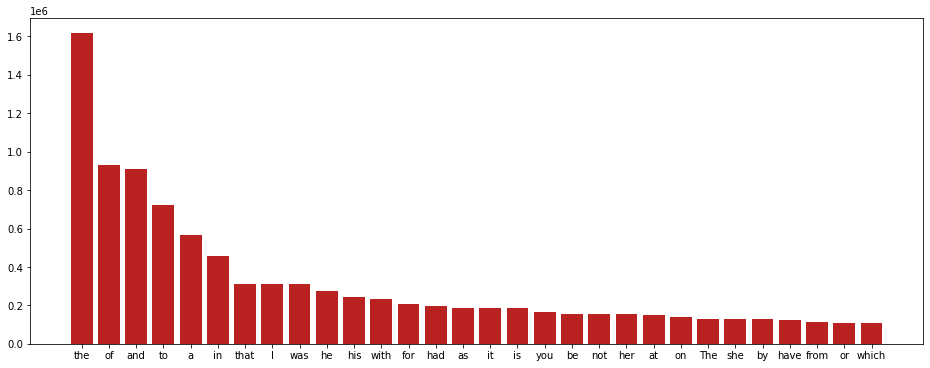

In [1]:
import matplotlib.pyplot as plt
import operator
print ('Plotting...')
freq = {}

# Read input and sort by frequency. Keep only top 30.
# Read Reducer Output
with open('./results/part-r-00000', 'rb') as csvfile:
    for line in csvfile.readlines():
        word, count = line.decode('UTF-8').split('\t')
        freq[word] = int(count)
srt = sorted(freq.items(), key=operator.itemgetter(1), reverse=True)[:30]

# Generate plot
plt.figure(figsize=(16,6))
plt.bar(range(len(srt)), [x[1] for x in srt], align='center', color='#ba2121')
plt.xticks(range(len(srt)), [x[0] for x in srt])
plt.show()

If everything is correct, the 3 most frequent words should be **`the`**, **`of`** and **`and`**.

## 3. Performance comparison

- Test your MapReduce with `gutenberg_x0.1.txt` and `gutenberg.txt`. For each test, **write down the running time**:

```
time yarn jar MapReduceWordCount.jar MapReduceWordCount /gutenberg_x0.1.txt /tmp/gut01/
time yarn jar MapReduceWordCount.jar MapReduceWordCount /gutenberg.txt /tmp/gut1/
```

- For reference, it takes 34s for gutenberg_x0.1.txt and it takes 3m6s for gutenberg.txt.

- We prepared a simple [wordcount program](./wordcount.py) in Python in this folder. Download it on your laptop (or the cluster NameNode) and test how long it takes to process these two datasets. **Annotate the times for the next exercise.**
    
```
python wordcount.py < /pathtoyourfile/gutenberg_x0.1.txt
python wordcount.py < /pathtoyourfile/gutenberg.txt
```

- For reference, it takes 5.724s for gutenberg_x0.1.txt in my local workstation and it takes 42.984s for gutenberg.txt. 

### 3.1 Plot
Compare the performance of the MapReduce vs the single-thread implementation of the word count algorithm for two different input sizes. Fill the time in seconds in the code below to plot the results.

In [ ]:

size_input = [1.9*10e2, 1.7*10e3] # the input size in MB
time_mapreduce = [0., 0.] # replace 0s with the time (in seconds) for the corresponding inputs
time_locallaptop = [0., 0.] # replace 0s with the time (in seconds) for the corresponding inputs


%matplotlib inline
# Import plot library
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(18,9))
plt.plot(size_input, time_mapreduce, '#f37626', label='MapReduce', linewidth=3.0)
plt.plot(size_input, time_locallaptop, '#00b300', label='Local laptop', linewidth=3.0, linestyle='dashed')

plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Input size (MB)')
plt.ylabel('Time (seconds)')
plt.title('Wall-time comparison')
plt.show()

### 3.2. Discussion

We have run some more tests. Here we present the running time for 3 configurations on HDInsight, one workstation and one laptop. The figures below are indicative only, because the performance of every machine depends on several factors.

- **MapReduce v1**: no combiner with default configuration (1 reducer)
- **MapReduce v2**: no combiner with 8 reduce tasks
- **MapReduce v3**: using combiner with default configuration (1 reducer)
- **MapReduce v4**: using combiner with 8 reduce tasks
- **Workstation**: using a local workstation (server)
- **Laptop**: using a local laptop

See our performance plot below:

<img src="./figures/three_configurations_discussions.jpg" style="width:800px;">

1. Which line corresponds to which setting?
1. Which is faster, MapReduce on your cluster or a local wordcount implementation? Why?
2. Based on your experiment, what input size is the approximate break-even point for time performance?
3. Why MapReduce is not performing better than local computation for small inputs?
4. How can you optimize the MapReduce performance for this job?

## 4. Querying JSON: The Language Confusion Dataset (optional)

In this task, we will develop a MapReduce application that processes a dataset from the [language game](http://data.greatlanguagegame.com.s3.amazonaws.com/confusion-2014-03-02.tbz2).

It contains rows of the following format:

```json
{"target": "Turkish",
 "sample": "af0e25c7637fb0dcdc56fac6d49aa55e",
 "choices": ["Hindi", "Lao", "Maltese", "Turkish"],
 "guess": "Maltese",
 "date": "2013-08-19",
 "country": "AU"}
```

Here, the `guess` field is what the user chose and the `target` field was the expected answer.

### 4.1. Set up

- Attach to the NameNode container:  `docker exec -it namenode /bin/bash`
- Download the data **on your local machine, not in the container**: `curl -O http://data.greatlanguagegame.com.s3.amazonaws.com/confusion-2014-03-02.tbz2`
- Extract the data: `tar -jxvf confusion-2014-03-02.tbz2`
- Copy the data to the NameNode container: `docker cp confusion-2014-03-02 namenode:/confusion-2014-03-02`
- Upload the data to HDFS: `hdfs dfs -put confusion-2014-03-02/confusion-2014-03-02.json /tmp/`

### 4.2. Query implementation

- You can start with the code provided in Task 3. Remove the old mapreduce directory, unzip `mapreduce.zip` and modify it accordingly.
- On the NameNode container, remove the old mapreduce directory: `rm -rf /mapreduce_path`
- The query to be implemented is:

**Find the number of games where the guessed language is correct (i.e., guess equal to the target one) and that language is Russian.**

- To parse a line of text, first add the next to the other imports:
```java
import com.google.gson.JsonObject;
import com.google.gson.JsonParser;
```

- Then, you can use the following to parse and access json elements:

```java
...
    JsonObject jsonObject = new JsonParser().parse(value.toString()).getAsJsonObject();
    jsonObject.get("target").getAsString();
...
```

To compile and run the code, follow the same steps as above for Exercise 2.2.
**Note: Make sure that the path to the json is the one on HDFS, not the one in the local container.**

## 5. Reverse engineering
Conceptually, a map function takes an input a key-value pair and emits a list of key-values pairs, while a reduce function takes in input a key with an associated list of values and returns a list of values or key-value pairs. Often the type of the final key and value is the same of the type of the intermediate data:

- map     `(k1,v1) --> list(k2,v2)`
- reduce  `(k2,list(v2))--> list(k2, v2)`


Analyze the following Map and Reduce functions, written in pseudo-code, and answer the questions below.

```js
function map(key, value)
  emit(key, value);
```

```js
function reduce(key, values[])
  z = 0.0
  for value in values:
    z += value
  emit(key, z / values.length())
```

**Questions**

1. Explain what is the result of running this job on a list of pairs with type ([string], [float]).
1. Write the equivalent SQL query.
1. Could you use this reduce function as combine function as well? Why or why not?
1. If your answer to the previous question was *yes*, does the number of different keys influences the effectiveness of the combine function? If you answer was *no*, can you change the map and reduce functions in such a way that the new reduce function can be used as combine function?

## 6. True or False
Say if the following statements are *true* or *false*, and explain why.

1. Each map function must generate the same number of key/value pairs as its input had.
1. The TaskTracker is responsible for scheduling map functions and reduce functions and make sure all nodes are correctly running.
1. The input key/value pairs of map functions are sorted by the key.
1. MapReduce splits might not correspond to HDFS block.
1. One single Reduce function is applied to all values associated with the same key.
1. Multiple Reduce functions can be assigned pairs with the same value.
1. In Hadoop MapReduce, the key-value pairs a Reduce function outputs must be of the same type as its input pairs.

## 7. Some more MapReduce and SQL

Design, in Python or pseudo-code, MapReduce functions that take a very large file of integers and produce as output:

1. The largest integer.
1. The average of all the integers.
1. The set of integers, but with each integer appearing only once.
1. The number of times each unique integer appears.
1. The number of distinct integers in the input.

For each of these, write the equivalent SQL query, assuming you have a column `values` that stores all the integers.

## 8. TF-IDF in MapReduce (optional)
Imagine we want to build a search engine over the Gutenberg dataset of ~3000 books. Given a word or a set of words, we want to rank these books according their relevance for these words. We need a metric to measure the importance of a word in a set of document...

### 8.1 Understand TF-IDF

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a statistic to determine the relative importance of the words in a set of documents. It is computed as the product of two statistics, term frequency (`tf`) and inverse document frequency (`idf`). 

Given a word `t`, a document `d` (in this case a book) and the collection of all documents `D`, we can define `tf(t, d)` as the number of times `t` appears in `d`. This gives us some information about the content of a document but because some terms (eg. "the") are so common, term frequency will tend to incorrectly emphasize documents which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms.

The inverse document frequency `idf(t, D)` is a measure of how much information the word provides, that is, whether the term is common or rare across all documents. It can be computed as:

![idf](./figures/idf.png)

where $|D|$ is the total number of documents and the denominator represents how many documents contain the word $t$ at least once. However, this would cause a division-by-zero exception if the user query a word that never appear in the dataset. A better formulation would be:

![idfs](./figures/idf_smooth.png)

Then, the `tdidf(t, d, D)` is calculated as follows:

![tdidf](./figures/tfidf.png)

A high weight in `tfidf` is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents.

### 8.2 Implement TF-IDF in MapReduce (pseudo-code)
Implement Mapper and Reducer functions in pseudo-code to compute TF-IDF. Assume each Mapper receives the document name as string key and the entire document content as string value. The output of your job should be a list of key-value pairs, where the key is a string in the form "document:word" and the value is the `tfidf` score for that document/word pair.

```js
function map(doc_id, doc_content)
  ...
```

```js
function reduce(key, values[])
  ...
```